# Translation of "Active information sampling varies across the cardiac cycle" by Kunzendorf et al (2019) study from R to Python

## Pre-Processing

Import all needed packages, disable Warning-notifications

In [1]:
import rdata
import numpy as np
import pandas as pd
import rdata
import matplotlib.pyplot as plt 
import scipy.stats as st
from urllib.request import urlopen

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

Import needed files from Github 

In [2]:
dataset_url = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/main_exg2_peaks_s_list.RData")
with urlopen(dataset_url) as dataset:
    pars_inc = rdata.parser.parse_file(dataset)
converted_inc = rdata.conversion.convert(pars_inc)
allinc = converted_inc["main_exg2_peaks_s_list"]

pre_fin = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/fin_sys_dur_s.RData")
with urlopen(pre_fin) as dataset:
    pars_fin = rdata.parser.parse_file(dataset)
converted_fin = rdata.conversion.convert(pars_fin)
r_tend = pd.DataFrame.from_dict(converted_fin)

pre_log = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/log_encode.RData")
with urlopen(pre_log) as dataset:
    pars_log = rdata.parser.parse_file(dataset)
converted_log = rdata.conversion.convert(pars_log)
log_enc = converted_log["log_encode"]


pre_bins = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/data_bins.RData")
with urlopen(pre_bins) as dataset:
    pars_bins = rdata.parser.parse_file(dataset)
converted_bins = rdata.conversion.convert(pars_bins)
data_bins = converted_bins["data_bins"]

Define needed variables and empty dataframes for following loops

In [3]:
needed_rows = 0
count = 0
allclicks = pd.DataFrame()
cardiac = pd.DataFrame()
allincs = pd.DataFrame()
rtend_df = pd.DataFrame()

Loop through every participant with eachs R-peaks and button presses to sort them into bins (binary) and find their relative onset (circular)

In [4]:
for key, values in allinc.items():

    singleinc = pd.DataFrame(values, columns=["r_peaks"]) 
   
    # calculate ibi for person
    ibi = singleinc["r_peaks"].diff() 
    ibi = ibi.shift(-1)
    singleinc["ibi"] = ibi
    
    # import r-tend intervall for each participant  
    rtend = r_tend["sys_dur_s"].iloc[count] 
    qonR = log_enc["qonR"].iloc[needed_rows]
    peplength = log_enc["pep"].iloc[needed_rows]
    crop = data_bins[data_bins.vp == key].crop.values
    qt = qonR + rtend # get complete length of systole from q to t wave 
    singleinc["qwave"] = singleinc["r_peaks"] - qonR
    ep = float(qt - peplength)
    singleinc["sys_end"] = singleinc.r_peaks + rtend
    # import file with clicks for each loop
    click = pd.DataFrame(log_enc["click1onset_ecgtime_s"][needed_rows: needed_rows +120])
    click.columns = ["clicks"]
  
    needed_rows = needed_rows + 120

    #create bins
    pep = []
    sys = []
    xtime = []
    dias = []

    # loop through clicks and sort them into bins (binary)
    for index, row in singleinc.iterrows():
        q = row["qwave"]
        r = row["r_peaks"]
        tend = row["sys_end"]
        xlen = 0.05
        next_q = singleinc.loc[index + 1, "qwave"] if index + 1 < len(singleinc) else float("inf") # infinitive
        
        pepclick = click.loc[(click["clicks"] >= q) & (click["clicks"] <= (q + peplength))]
        syst = click.loc[(click["clicks"] > (q + peplength)) & (click["clicks"] <= tend)] # sorts into systole if click between r peak and systole-end (twave end)
        xperiod = click.loc[(click["clicks"] > tend) & (click["clicks"] <= (tend + xlen))]
        diast = click.loc[(click["clicks"] > (tend + xlen)) & (click["clicks"] < next_q)] # sorts into diastole if click between systole end and next r peak
        pep.extend(pepclick["clicks"].tolist()) # appending binned values to list 
        sys.extend(syst["clicks"].tolist()) # appending binned values to list 
        xtime.extend(xperiod["clicks"].tolist()) # appending binned values to list 
        dias.extend(diast["clicks"].tolist())   

    pep_df = pd.DataFrame({"clicks": pep}) 
    sys_df = pd.DataFrame({"clicks": sys}) 
    x_df = pd.DataFrame({"clicks": xtime}) 
    dias_df = pd.DataFrame({"clicks": dias})
    pep_clicks = len(pep_df)
    sys_clicks =len(sys_df)
    x_clicks = len(x_df)
    dias_clicks = len(dias_df)

    # circular transformation
    for index, row in click.iterrows():
        diff = row["clicks"] - singleinc.r_peaks 
        diff = diff [diff > 0]
        clos_r_idx = diff.idxmin()
        click.loc[index, "clos_r"] = singleinc.r_peaks[clos_r_idx]
        click.loc[index, "clos_ibi"] = singleinc.ibi[clos_r_idx]
        click.loc[index, "rel"] = diff[clos_r_idx]

    click_circ =[]
    for index, row in click.iterrows():
        res = row["rel"] * 2 * np.pi  * (1 / row["clos_ibi"]) 
        click_circ.append(res)
    click["circ"] = click_circ
    
    # define ratios of clicks in phases of the cardiac cycle to take different phase lengths into account (other cardiac phases are not important here)
    rr = click.clos_ibi.mean()
    diaslength = rr - qt - 0.050
    sysrel = (sys_clicks / 120) / (ep / rr) # syspat is length of sys
    diasrel = (dias_clicks / 120) / ( diaslength / rr) # if rel > 1 higher probability to click during this phase
    
    # calculate circular mean for each participant
    circ_mean = st.circmean(click_circ)
    if circ_mean < 0:
        circ_mean = circ_mean + 2 * np.pi

    # append values to dataframes
    magn = np.sqrt((np.square(np.sum(np.sin(click_circ)))) + (np.square(np.sum(np.cos(click_circ)))))
    temp = pd.DataFrame({"inc": key, "sys": sys_clicks, "dias": dias_clicks, "ibi": rr, "pep": pep_clicks, "x": x_clicks, "sysrel": sysrel, "diasrel": diasrel, "pep_len": peplength, "crop_len": crop, "dias_len": diaslength, "qonR" : qonR, "circ_mean": circ_mean, "magnitude": magn})
    allclicks = pd.concat([allclicks, temp], ignore_index = True)
    singleinc["inc"] = key
    click["inc"] = key
    
    rtend_new = pd.DataFrame({'inc': [key], 'sys_dur': [rtend]})
    rtend_df = pd.concat([rtend_df, rtend_new])
    allincs = pd.concat([allincs, click], ignore_index = True)
    cardiac = pd.concat([cardiac, singleinc], ignore_index = True)
    count = count + 1


Save created data frames as csv files for further analyses to save time when restarting the programm

In [6]:
cardiac.to_csv("_dataframes/_dataframes_csv/cardiac.csv", index = False)
allincs.to_csv("_dataframes/_dataframes_csv/allincs.csv", index = False)
rtend_df.to_csv("_dataframes/_dataframes_csv/rtend.csv", index = False)
allclicks.to_csv("_dataframes/_dataframes_csv/allclicks.csv", index = False)



--------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Statistical Testing 


Load csv files from above

In [8]:
cardiac = pd.read_csv("_dataframes/_dataframes_csv/cardiac.csv")
allincs = pd.read_csv("_dataframes/_dataframes_csv/allincs.csv")
r_tend = pd.read_csv("_dataframes/_dataframes_csv/rtend.csv")
allclicks = pd.read_csv("_dataframes/_dataframes_csv/allclicks.csv")

Input participants you want to look at (if none are inserted in "excluded" the analysis looks at all participants) <br>
Participant inc11, inc40, inc41 are excluded because of high bloodpressure and a high heartrate

In [9]:
included = [] 
excluded = [11, 40, 41] 

Filtering out the data for the above chosen participants

In [10]:
if included:
    included = [f"inc{p:02}" for p in included]
if excluded:
    excluded = [f"inc{p:02}" for p in excluded]

if included:
    spec_incs = allincs[allincs["inc"].isin(included)]
    spec_cardiac = cardiac[cardiac["inc"].isin(included)]
    spec_clicks = allclicks[allclicks["inc"].isin(included)]
    spec_rtend = r_tend[r_tend["inc"].isin(included)]

elif excluded:
    spec_incs = allincs[~allincs["inc"].isin(excluded)]
    spec_cardiac = cardiac[~cardiac["inc"].isin(excluded)]    
    spec_clicks = allclicks[~allclicks["inc"].isin(excluded)]
    spec_rtend = r_tend[~r_tend["inc"].isin(excluded)]

else:
    spec_incs = allincs
    spec_cardiac = cardiac
    spec_clicks = allclicks
    spec_rtend = rtend

Testing mean, standard deviation and standard error of systolic and diastolic ratios

In [15]:
print("Mean of all systolic ratios: ", "\t", "\t", "\t", spec_clicks["sysrel"].mean())
print("Mean of all diastolic ratios: ","\t", "\t", "\t", spec_clicks["diasrel"].mean())
print("Standard-derivation of all systolic ratios: ", "\t", np.std(spec_clicks["sysrel"]))
print("Standard-derivation of all diastolic ratios: ","\t", np.std(spec_clicks["diasrel"]))
print("Standard error of systolic ratio: ", "\t", "\t", st.sem(spec_clicks.sysrel))
print("Standard error of diastolic ratio: ", "\t", "\t", st.sem(spec_clicks.diasrel))

Mean of all systolic ratios:  	 	 	 1.054931288468781
Mean of all diastolic ratios:  	 	 	 0.9714682801309014
Standard-derivation of all systolic ratios:  	 0.13894318397832348
Standard-derivation of all diastolic ratios:  	 0.08042147044926647
Standard error of systolic ratio:  	 	 0.021439398742254565
Standard error of diastolic ratio:  	 	 0.012409302299199197


Testing correlation between systolic and diastolic ratio

In [17]:
print(st.ttest_rel(spec_clicks.sysrel, spec_clicks.diasrel))
print(st.wilcoxon(spec_clicks.sysrel, spec_clicks.diasrel))
def cohens (x,y):
    mean_diff = np.mean(x-y)
    pooled_sd = np.std(y-x)
    cohens_d = mean_diff / pooled_sd
    return cohens_d

print("Cohens d: ", "\t", cohens(spec_clicks.sysrel, spec_clicks.diasrel))

TtestResult(statistic=2.7600175322533467, pvalue=0.008529451826475656, df=42)
WilcoxonResult(statistic=263.0, pvalue=0.01040263543995934)
Cohens d:  	 0.42587995118079736


Testing if systolic and diastolic ratio are normally distributed

In [18]:
print(st.shapiro(spec_clicks.sysrel))
print(st.shapiro(spec_clicks.diasrel))

ShapiroResult(statistic=0.9817510648822774, pvalue=0.7164323077076338)
ShapiroResult(statistic=0.9758061429706271, pvalue=0.49052854783646027)


Computing circular mean and its standard deviation of all participants

In [20]:
print("circular mean of all participants circular means: ", "\t", "\t", st.circmean(spec_clicks["circ_mean"])/np.pi)
print("standard derivation of all participants circular means: ", "\t", st.circstd(spec_clicks["circ_mean"])/np.pi)   

circular mean of all participants circular means:  	 	 0.32821587096665944
standard derivation of all participants circular means:  	 0.5218106853388793


--------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Plotting Results

### Histogram with distribution of systolic and diastolic ratios of all participants

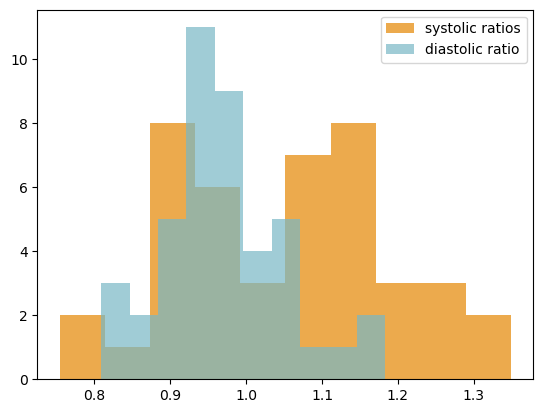

In [23]:
fig, ax = plt.subplots()
ax.hist(spec_clicks.sysrel, alpha=0.7, label ="systolic ratios", color = "#E58601", bins= 10)
ax.hist(spec_clicks.diasrel, alpha=0.7, label = "diastolic ratio", color = "#78B7C5", bins= 10)
ax.legend(loc="upper right") 
#plt.title("Distribution of Systolic and Diastolic Ratios") 
plt.savefig("_figures/_figures_translation/histo_distribution_of_ratios.png", dpi=350) 
plt.show()

### Histogram of all clicks from all participants sorted into systole, x-period, diastole, pep

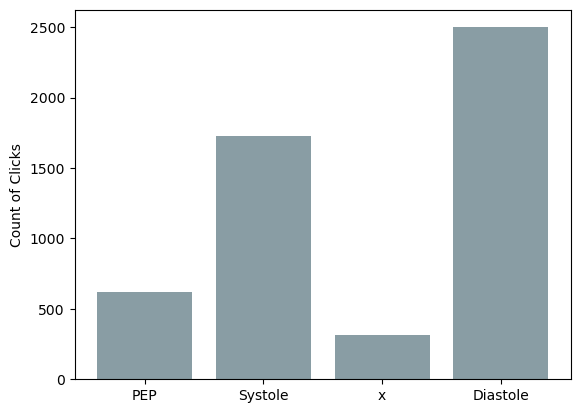

In [24]:
fig, ax = plt.subplots()
ax.bar(["PEP","Systole", "x", "Diastole"],[spec_clicks.pep.sum(), spec_clicks.sys.sum(), spec_clicks.x.sum(), spec_clicks.dias.sum()], color = "#899DA4")
plt.ylabel("Count of Clicks")
#plt.title("Distribution of 120 Clicks within the Cardiac Cycle")
plt.savefig("_figures/_figures_translation/distribution_of_clicks.png", dpi=350) 
plt.show()

### Binary scatter plot <br>
creating a scatter-plot with one point being one participant with their systolic and diastolic ratio

defining limits for the quadrants

In [25]:
small_sys = spec_clicks.sysrel < 1
big_sys = spec_clicks.sysrel > 1
small_dias = spec_clicks.diasrel < 1
big_dias = spec_clicks.diasrel > 1
sys_mean = spec_clicks["sysrel"].mean()
dias_mean = spec_clicks["diasrel"].mean()

Plotting the ratios: systolic quadrant (orange), diastolic quadrant (blue), undefinded (grey)

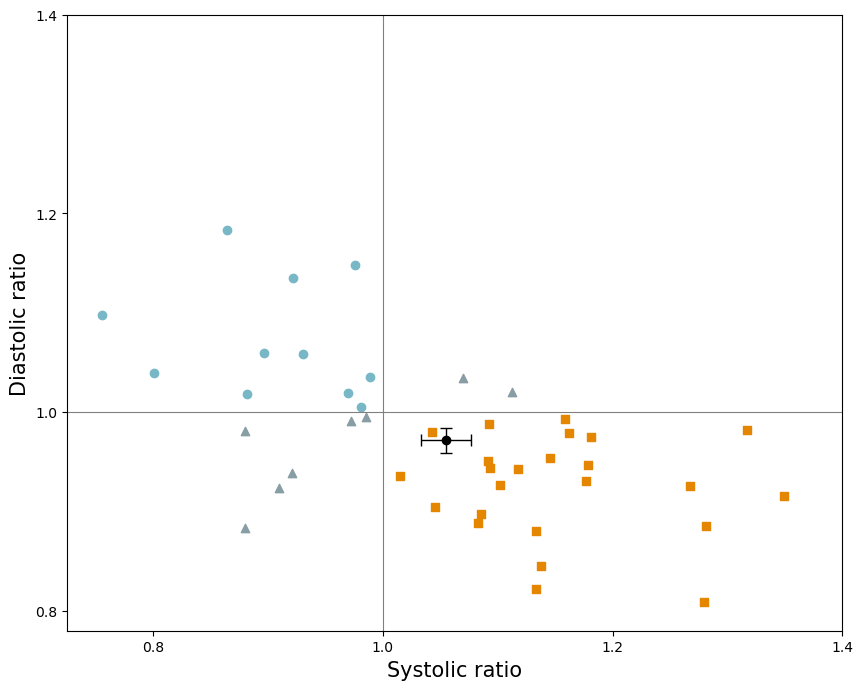

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.axline((1, 0.8), (1, 1.2 ), linewidth = 0.8, color = "gray")
ax.axline((0.8, 1), (1.2, 1), linewidth = 0.8, color = "gray")
ax.scatter(spec_clicks[(small_sys) & (small_dias)].sysrel, spec_clicks[(small_sys) & (small_dias)].diasrel, color="#899DA4", marker="^")
ax.scatter(spec_clicks[(small_sys) & (big_dias)].sysrel, spec_clicks[(small_sys) & (big_dias)].diasrel, color="#78B7C5")
ax.scatter(spec_clicks[(big_sys) & (small_dias)].sysrel, spec_clicks[(big_sys) & (small_dias)].diasrel, color="#E58601",marker= "s")
ax.scatter(spec_clicks[(big_sys) & (big_dias)].sysrel, spec_clicks[(big_sys) & (big_dias)].diasrel, color="#899DA4", marker="^")
plt.errorbar( sys_mean, dias_mean, xerr = st.sem(spec_clicks.sysrel), yerr= st.sem(spec_clicks.diasrel),fmt='o', color = "black", elinewidth=1, capsize=4)
plt.xlabel("Systolic ratio", fontsize=15 )
plt.ylabel("Diastolic ratio", fontsize = 15)
plt.xticks([0.8, 1.0, 1.2, 1.4])
plt.yticks([0.8, 1.0, 1.2, 1.4])
plt.rcParams["figure.figsize"]= [4.5,4.5]
#plt.title("Systolic and Diastolic Ratios of all Participants") 
plt.savefig("_figures/_figures_translation/binary_scatterplot.png", dpi=350) 
plt.show()

### Circular plot of single participant

Insert chosen participant for first level analysis

In [28]:
inc = 25

Defining variables adjusted to the chosen participant

In [29]:
inc = f"inc{inc:02}"
circ_trans = 2 * np.pi * (1/ allclicks[allclicks["inc"] == inc].ibi.iloc[0])
sys_start = allclicks[allclicks["inc"] == inc].crop_len.iloc[0] * circ_trans
sys_end = r_tend[r_tend["inc"] == inc].sys_dur.iloc[0] * circ_trans
dias_start = sys_end + (0.05  * circ_trans)
dias_end = dias_start + (allclicks[allclicks["inc"] == inc].dias_len.iloc[0] * circ_trans)

circ_clicks = allincs[allincs["inc"] == inc].circ.sort_values()
mean = allclicks[allclicks["inc"] == inc].circ_mean.iloc[0]
magn = allclicks[allclicks["inc"] == inc].magnitude.iloc[0]/len(circ_clicks)

Defining parameters for the circular density visualization

In [30]:
mu = st.circmean(circ_clicks)
sin_sum = np.sum(np.sin(circ_clicks))
cos_sum = np.sum(np.cos(circ_clicks))

two_circ_clicks = pd.concat([circ_clicks[circ_clicks > np.pi] - 2*np.pi, circ_clicks, circ_clicks[circ_clicks < np.pi] + 2*np.pi], ignore_index=True)
kernel = st.gaussian_kde(two_circ_clicks, bw_method=.05)
density= kernel.pdf(two_circ_clicks)
ran = len(two_circ_clicks[two_circ_clicks < 0])

r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

Plotting the distribution of participants 120 clicks across the cycle with Phase lengths starting with colored line (systole: orange; diastole: blue) and ending with a dashed one; <br>
The circular density is shown as a grey line around the circle

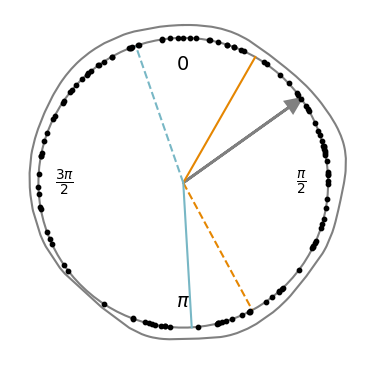

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.linspace(0, 2*np.pi, 100), r , color = "gray", label = "Density-Minimum")
ax.plot(two_circ_clicks[ran-1:ran+120], density[ran-1:ran+120] +1, color="gray", label="Von Mises Density")
ax.plot([sys_start,sys_start], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end,sys_end], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start,dias_start], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end,dias_end], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.scatter(circ_clicks, np.ones(120), s = 10, color = "black", zorder = 2)
ax.arrow(mean, 0, 0, 0.9, color="gray", head_width=0.1, head_length=0.1, lw= 2)
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5 ))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines["polar"].set_visible(False)
ax.tick_params(axis="x", pad=-50) 
ax.grid(False)
#plt.title("Circular Click Distribution " + inc) 
#plt.legend(loc = "upper left")
plt.savefig("_figures/_figures_translation/circular_inc25.png", dpi=350) 
plt.show()

In [37]:
print("Circular button press Mean for chose participant: ", "\t", mean/np.pi)
print("Mean Resultant Length of Mean above: " ,"\t" ,"\t", "\t", magn)

Circular button press Mean for chose participant:  	 0.3026261017223828
Mean Resultant Length of Mean above:  	 	 	 0.14584204405360682


### Circular histogram showing all clicks of all participants over the cardiac cycle

Insert number of bins wanted for the histogram

In [38]:
bin_num = 30 

Defining needed variables for coloring and sorting

In [41]:
data = spec_incs["circ"]
r_tend_mean = spec_rtend.sys_dur.mean() * 2 * np.pi
r_tend_std = spec_rtend.sys_dur.std() * 2 * np.pi
systole = data[data < r_tend_mean]
diastole = data[data > r_tend_mean]
binsize = round(r_tend_mean / (2 * np.pi) * bin_num)

Plotting the histogram with systole (orange) and diastole (blue) parted by the mean systolic onset of all participants

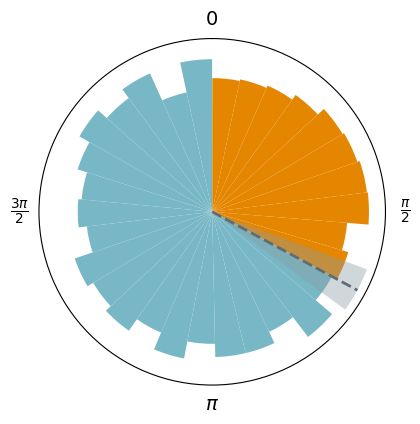

In [42]:
ax = plt.subplot(projection="polar")
ax.hist(systole, bins=binsize, color="#E58601")
ax.hist(diastole, bins=(bin_num - binsize), color="#78B7C5")
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.plot([r_tend_mean, r_tend_mean], [0, 200], color="#5f6d72", linestyle="--", linewidth=2, label = "mean of all r-tend-intervalls")  # mean of r t end
ax.bar(x = r_tend_mean, height= 200, width = r_tend_std * 2, color = "#899DA4",alpha = 0.4)
#ax.set_title("Circular Histogramm of Clicks from all Participants")
ax.grid(False)
#plt.legend(loc="lower right")
plt.savefig("_figures/_figures_translation/circular_histo_all.png", dpi=350) 
plt.show()

In [44]:
print("Mean of systolic onsets from all participants: ","\t" ,r_tend_mean/np.pi)
print("Standard deviation of above mean: ", "\t" ,"\t", "\t" ,r_tend_std/np.pi)

Mean of systolic onsets from all participants:  	 0.6575899345930233
Standard deviation of above mean:  	 	 	 0.04430297535614479


### Circular plot of circular means from all incs <br>
Plot showing the circular mean of each participant as a dot as well as the overall circular density

Defining different parts and phases of the cardiac cycle

In [46]:
circ_means = spec_clicks["circ_mean"].sort_values()

ibi_circ = []
for ibi in spec_clicks["ibi"]:
    ibi_trans = (2 * np.pi) / ibi 
    ibi_circ.append(ibi_trans)
spec_clicks["ibi_circ"] = ibi_circ 

circ_trans_all = np.mean(spec_clicks["ibi_circ"])

crop_circ = []
for crop in spec_clicks["crop_len"]:
    crop_trans = circ_trans_all * crop
    crop_circ.append(crop_trans)
spec_clicks["crop_circ"] = crop_circ 

rt_circ = []
for rt in spec_rtend["sys_dur"]:
    rt_trans = circ_trans_all * rt
    rt_circ.append(rt_trans)
spec_rtend["rt_circ"] = rt_circ 

dias_circ = []
for dias in spec_clicks["dias_len"]:
    dias_trans = circ_trans_all * dias
    dias_circ.append(dias_trans)
spec_clicks["dias_circ"] = dias_circ 

sys_start_all = np.mean(spec_clicks["crop_circ"])
sys_end_all = np.mean(spec_rtend["rt_circ"])
dias_start_all = np.mean(sys_end_all + (0.05 * circ_trans_all))
dias_end_all = np.mean(dias_start_all + dias_circ)

Computing the circular density

In [47]:
circ_means = circ_means.sort_values()
sin_sum_spec = np.sum(np.sin(circ_means))
cos_sum_spec = np.sum(np.cos(circ_means))
mu_spec = st.circmean(circ_means)
spec_magn = np.sqrt(np.square(sin_sum_spec) + (np.square(cos_sum_spec))) / len(circ_means)

two_circ_means = pd.concat([circ_means[circ_means > np.pi] - 2*np.pi, circ_means, circ_means[circ_means < np.pi] + 2*np.pi], ignore_index=True)
all_kernel = st.gaussian_kde(two_circ_means, bw_method=.1)
all_density= all_kernel.pdf(two_circ_means)
ran_all = len(two_circ_means[two_circ_means < 0])
r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

In [ ]:
nBoot = 100  # default = 10000, switch to 100 if necessary
vplist = list(spec_rtend["inc"])  # unique(log_encode$vp) # list of participants

out = []
buffer = []
bwparam = 0.5 # bandwidth parameter

for i in range(nBoot):  # repeat bootstrap procedure nBoot times
    vplist_boot = np.random.choice(vplist, size=len(vplist), replace=True)  # draw bootstrap sample
    buffer = []
    for j in range(len(vplist_boot)):  # compute circular density for each participant in sample
        x = spec_incs[spec_incs["inc"] == vplist_boot[j]].circ.values
        gauss_kde = st.gaussian_kde(x, bw_method=.1)
        dens= gauss_kde.pdf(x)
        buffer.append(dens)
    buffer = np.array(buffer)  
    mean_dens = np.mean(buffer)
    out.append(mean_dens)

out = np.array(out)

out_1 = []
for num in out:
    out_1.append(num+1)     


In [ ]:
ci_upper = []
ci_lower = []
ci_median = []

for i in range(len(out)):
    ci_lower.append(np.quantile(out[:, i], 0.025))  # 2.5% percentile
    ci_upper.append(np.quantile(out[:, i], 0.975))  # 97.5% percentile
    ci_median.append(np.quantile(out[:, i], 0.5))   # median

ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)
ci_median = np.array(ci_median)

# Define the uniform circular density function
def dcircularuniform(x):
    return np.ones_like(x) / (2 * np.pi)

# Find indices where ci_lower is significantly higher than the uniform distribution
markup_upper = np.where(ci_lower > dcircularuniform(1))[0]

# Find indices where ci_upper is significantly lower than the uniform distribution
markup_lower = np.where(ci_upper < dcircularuniform(1))[0]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Plotting means and density (grey), coloration as in circular plot for single participant

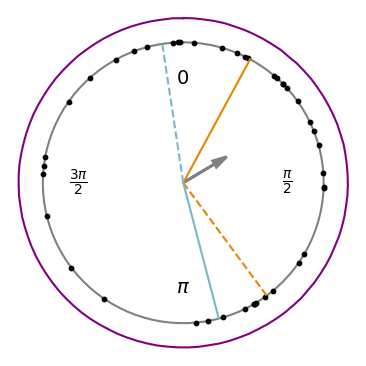

In [ ]:
theta = np.linspace(0, 2 * np.pi, 100)
ax = plt.subplot(projection="polar")
ax.plot(np.linspace(0, 2* np.pi, 100), r , color = "gray", label = "Density-Minimum")
ax.scatter(circ_means, np.ones_like(circ_means), s = 10, color = "black", zorder = 2)
#ax.plot(two_circ_means[ran_all - 1 : ran_all + len(circ_means)], all_density[ran_all - 1 : ran_all + len(circ_means)] +1, color="gray", label="Von Mises Density")
ax.arrow(mu_spec, 0, 0, spec_magn, color="gray", head_width=0.2, head_length=0.1, lw=2)
ax.plot(theta, out_1, color="purple")
ax.plot([sys_start_all,sys_start_all], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end_all,sys_end_all], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start_all,dias_start_all], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end_all,dias_end_all], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines['polar'].set_visible(False)
ax.grid(False)
ax.tick_params(axis="x", pad=-60)  
#ax.set_title("Circular Histogramm of Circular Means of all Participants")
#plt.legend(loc="lower right")
plt.savefig("_figures/_figures_translation/circ_means.png", dpi=350) 
plt.show()

In [48]:
print("Circular button press Mean for all circular means: ", "\t", mu_spec/np.pi)
print("Mean Resultant Length of Mean above: " ,"\t" ,"\t", "\t", spec_magn)

Circular button press Mean for all circular means:  	 0.32821587096665944
Mean Resultant Length of Mean above:  	 	 	 0.260883982198851
